In [1]:
import numpy as np
# import vunet
# import vunet_simple as vunet
import vunet_1 as vunet
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

import h5py

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [3]:
import tensorflow as tf
from keras import backend as K

# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.85

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

#### Load/select data

In [4]:
model_string = 'vunet'
output_dir = 'saved_models/'
case_string = 'horizontal_16w'
data_dir = '/data/cees/zjin/cs231n/project/var-unet/data/'

# hf_r = h5py.File(data_dir + case_string + '.hdf5', 'r')
hf_r = h5py.File(data_dir + case_string + '_aug.hdf5', 'r')
data_train = np.array(hf_r.get('data_train'))
data_eval = np.array(hf_r.get('data_eval'))
hf_r.close()

print(data_train.shape)
print(data_eval.shape)

n_trial_data = 1800
data_train_trial = data_train[:n_trial_data,...]
print(data_train_trial.shape)

n_eval_data = 200
data_eval_trial = data_eval[:n_eval_data,...]
print(data_eval_trial.shape)

(1800, 128, 128, 3, 2)
(200, 128, 128, 3, 2)
(1800, 128, 128, 3, 2)
(200, 128, 128, 3, 2)


In [5]:
# data_train_trial shape (?, 128, 128, 3, 2)
train_x_y_hat0 = data_train_trial[..., 0]# xc
train_y_hat0 = data_train_trial[..., [0], 1] #c
train_x_hat0 = data_train_trial[..., 1:, 1] # x

print(train_x_y_hat0.shape)
print(train_y_hat0.shape)
print(train_x_hat0.shape)

eval_x_y_hat0 = data_eval_trial[..., 0]# xc
eval_y_hat0 = data_eval_trial[..., [0], 1] #c
eval_x_hat0 = data_eval_trial[..., 1:, 1] # x

print(eval_x_y_hat0.shape)
print(eval_y_hat0.shape)
print(eval_x_hat0.shape)

# eval_x_y_hat0, eval_y_hat0, eval_x_hat0

(1800, 128, 128, 3)
(1800, 128, 128, 1)
(1800, 128, 128, 2)
(200, 128, 128, 3)
(200, 128, 128, 1)
(200, 128, 128, 2)


In [6]:
epoch = 40
learning_rate = 5e-4 # default 1e-3
train_nr = data_train_trial.shape[0]
eval_nr = data_eval_trial.shape[0]


input_shape = (128,128,3)
w_shape = (128,128,1)
output_shape = (128,128,2)


# enc_up, hidden_shapes = vunet.create_enc_up(input_shape, n_scales = 8)
# enc_down = vunet.create_enc_down(latent_shape)
# dec_up = vunet.create_dec_up(output_shape, n_scales = 8) # only c input
# dec_down = vunet.create_dec_down(hidden_shapes, latent_shape, n_scales = 8)

enc_up, hidden_shapes = vunet.create_enc_up(w_shape, n_scales = 5)
enc_down = vunet.create_enc_down(hidden_shapes[-1])
dec_up = vunet.create_dec_up(input_shape, n_scales = 5) # only c input
dec_down = vunet.create_dec_down(hidden_shapes, hidden_shapes[-1], output_shape, n_scales = 5)

enc_up.load_weights(output_dir + 'enc_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
enc_down.load_weights(output_dir + 'enc_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_up.load_weights(output_dir + 'dec_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_down.load_weights(output_dir + 'dec_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

In [7]:
xc = Input(shape=input_shape) # perm + well location
c = Input(shape=w_shape) # well location

hs = enc_up(c)
z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
gs = dec_up(xc)
x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

v_unet_model = Model([xc, c], [x_hat])

In [8]:
x_hat_pred_eval = v_unet_model.predict([eval_x_y_hat0, eval_y_hat0])
print(x_hat_pred_eval.shape)

(200, 128, 128, 2)


In [9]:
x_hat_pred_train = v_unet_model.predict([train_x_y_hat0, train_y_hat0])
print(x_hat_pred_train.shape)

(1800, 128, 128, 2)


## Train simulation results

In [10]:
print(x_hat_pred_train.shape)
print(train_x_hat0.shape)

err = np.abs(x_hat_pred_train - train_x_hat0)
rel_err = np.sum(err, axis=(1,2,3)) / np.sum(train_x_hat0, axis=(1,2,3))
print(rel_err.shape)
print(np.mean(rel_err))

(1800, 128, 128, 2)
(1800, 128, 128, 2)
(1800,)
0.07615567399089958


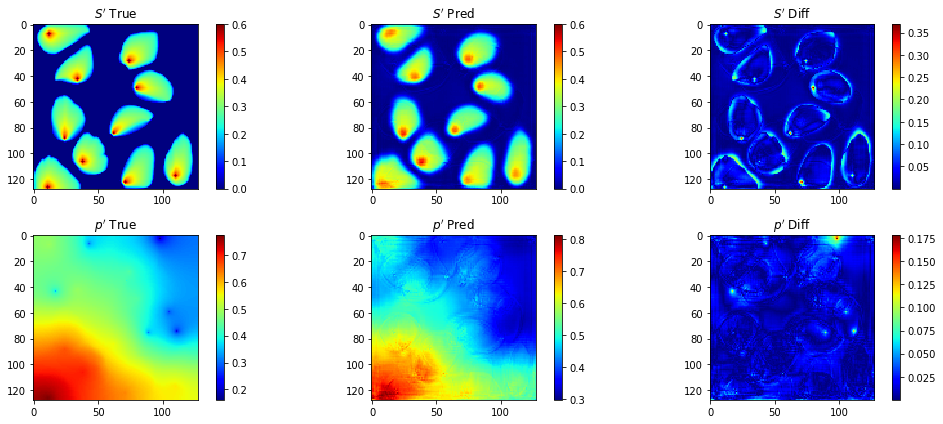

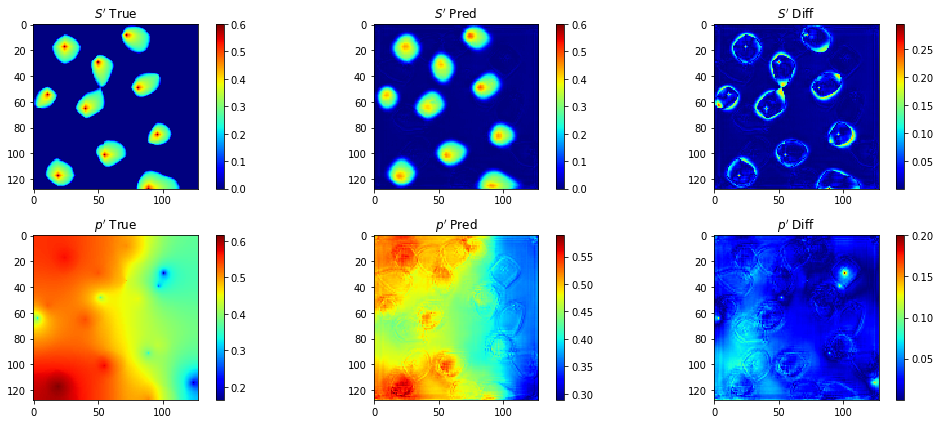

In [11]:
# train_x_y_hat0 = data_train_trial[..., 0]# xc
# train_y_hat0 = data_train_trial[..., [0], 1] #c
# train_x_hat0 = data_train_trial[..., 1:, 1] # x

n_plot_train = 2

for k in range(n_plot_train):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2,3,1)
    plt.title('$S^{\prime}$ True')
    plt.imshow(train_x_hat0[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,2)
    plt.title('$S^{\prime}$ Pred')
    plt.imshow(x_hat_pred_train[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,3)
    plt.title('$S^{\prime}$ Diff')
    plt.imshow(np.abs(x_hat_pred_train[k, ..., 0] - train_x_hat0[k, ..., 0]))
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,4)
    plt.imshow(train_x_hat0[k, ..., 1])
    plt.title('$p^{\prime}$ True')
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,5)
    plt.imshow(x_hat_pred_train[k, ..., 1]) 
    plt.title('$p^{\prime}$ Pred')
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,6)
    plt.imshow(np.abs(x_hat_pred_train[k, ..., 1] - train_x_hat0[k, ..., 1]))
    plt.title('$p^{\prime}$ Diff')
    plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
    plt.savefig("figs/" + case_string + model_string + "_train_results_%dtrain_%depoch.pdf"%(train_nr, epoch), format='pdf')
    plt.show()

    

## Test simulation results

In [12]:
print(x_hat_pred_eval.shape)
print(eval_x_hat0.shape)

err_eval = np.abs(x_hat_pred_eval - eval_x_hat0)
rel_err_eval = np.sum(err_eval, axis=(1,2,3)) / np.sum(eval_x_hat0, axis=(1,2,3))
print(rel_err_eval.shape)
print(np.mean(rel_err_eval))

(200, 128, 128, 2)
(200, 128, 128, 2)
(200,)
0.09758135780686081


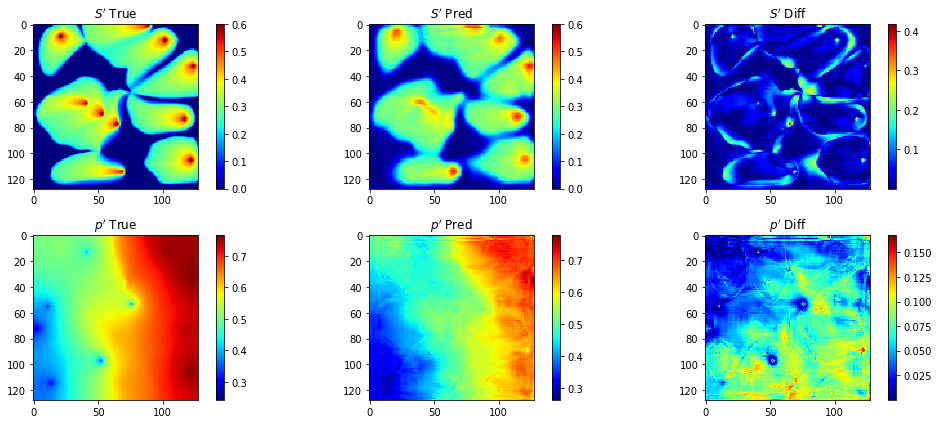

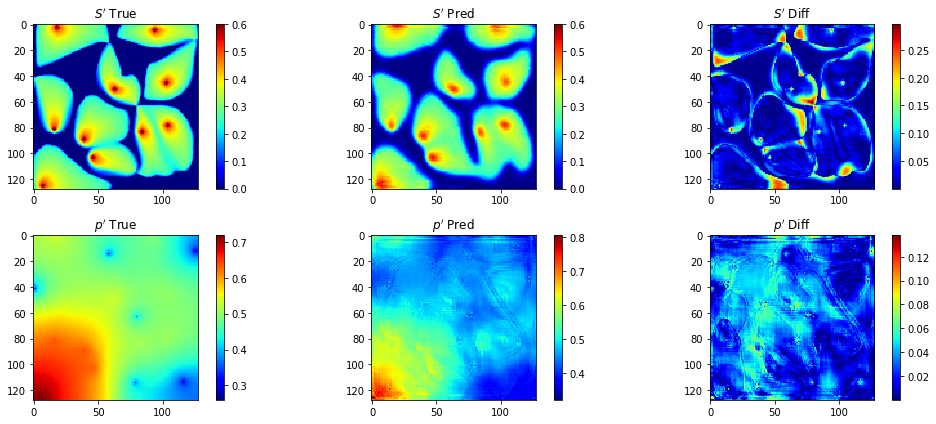

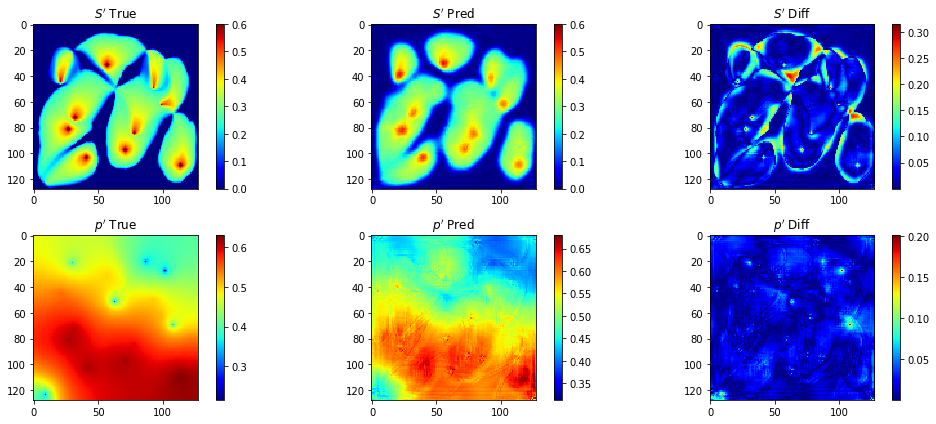

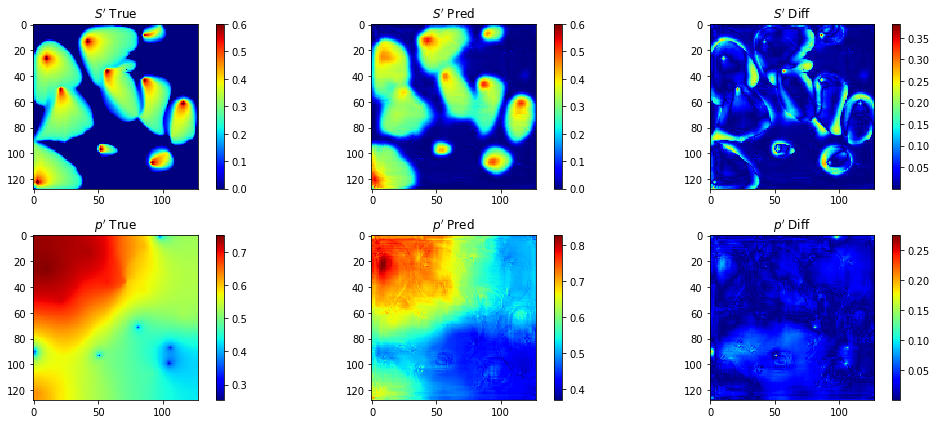

In [13]:
# eval_x_y_hat0 = data_eval_trial[..., 0]# xc
# eval_y_hat0 = data_eval_trial[..., [0], 1] #c
# eval_x_hat0 = data_eval_trial[..., 1:, 1] # x

n_plot_train = 4

for k in range(n_plot_train):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2,3,1)
    plt.title('$S^{\prime}$ True')
    plt.imshow(eval_x_hat0[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,2)
    plt.title('$S^{\prime}$ Pred')
    plt.imshow(x_hat_pred_eval[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,3)
    plt.title('$S^{\prime}$ Diff')
    plt.imshow(np.abs(x_hat_pred_eval[k, ..., 0] - eval_x_hat0[k, ..., 0]))
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,4)
    plt.imshow(eval_x_hat0[k, ..., 1])
    plt.title('$p^{\prime}$ True')
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,5)
    plt.imshow(x_hat_pred_eval[k, ..., 1]) 
    plt.title('$p^{\prime}$ Pred')
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,6)
    plt.imshow(np.abs(x_hat_pred_eval[k, ..., 1] - eval_x_hat0[k, ..., 1]))
    plt.title('$p^{\prime}$ Diff')
    plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
    plt.savefig("figs/" + case_string + model_string + "_eval_results_%dtrain_%depoch.pdf"%(train_nr, epoch), format='pdf')
    plt.show()

    